In [27]:
import sqlite3
import pandas as pd
import pathlib
import json
import re
from tqdm import tqdm
from bertopic import BERTopic
import pickle
import bz2
from tqdm.contrib.concurrent import process_map
from collections import defaultdict
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from itertools import cycle
from scipy.stats import bernoulli
import random
from operator import concat
from functools import reduce

see get_seeded_mp.py for the script to pull comments from the reddit data wrt., seed terms

see cut_comments which takes the comments.json and indices.json output from get_seeded_mp.py and extracts, for this analysis, the 2015 'poor comments'

see topic_model.py which performs topic modelling on the above 2015 poor comments subset. see the script for details

In [28]:
import sys
sys.version

'3.10.4 (main, Mar 31 2022, 03:37:37) [Clang 12.0.0 ]'

## Load comments, indices, config

In [29]:
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

In [30]:
with open('comments.json', 'r', encoding='utf-8') as f:
    comments = json.load(f)

In [31]:
with open('indices.json', 'r', encoding='utf-8') as f:
    indices = json.load(f)
indices = {k:[tuple(p) for p in indices[k]] for k in tqdm(indices.keys())}

100%|███████████████████████████████████████████| 41/41 [00:00<00:00, 61.39it/s]


## Load the topic_model

In [32]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic.load("topic_model.safetensors", embedding_model=embedding_model)

### get a dataframe of topics wrt., all comments

In [33]:
ordered_comments = reduce(concat, [comments[seed] for seed in comments.keys()])
df_topic = topic_model.get_document_info(ordered_comments)

In [34]:
df_topic.shape

(1904437, 7)

### collapse rows which are the same comment (have the same comment index)

In [35]:
df_topic['index'] = [index for seed in indices.keys() for index in indices[seed]]
df_topic = df_topic.drop_duplicates(subset=['index'], keep='first')

In [36]:
df_topic.shape

(1830354, 8)

## rows by context type

In [37]:
poor_indices = set([index for seed in config['wealth_seeds']['poor_seeds'] for index in indices[seed]])
rich_indices = set([index for seed in config['wealth_seeds']['rich_seeds'] for index in indices[seed]])
neutral_indices = set(indices['neutral_sample'])
black_indices = set([index for seed in config['other_seeds']['black_seeds'] for index in indices[seed]])
n_indices = set([index for seed in config['other_seeds']['n_seeds'] for index in indices[seed]])

In [38]:
display(len(poor_indices.intersection(rich_indices)))
display(len(poor_indices.intersection(black_indices)))
display(len(neutral_indices.intersection(black_indices)))
display(len(poor_indices.intersection(n_indices)))
display(len(neutral_indices.intersection(n_indices)))

14397

4395

995

413

290

In [39]:
# pure poor_context indices (as not coincident with rich) and vice-versa
poor_indices_pure = poor_indices - rich_indices
rich_indices_pure = rich_indices - poor_indices

# RQ1

## flag comments as containing a key word from selected topics

In [40]:
RQ1_selected = [
    ('police', 'cops ', 'police officer', 'cop ',), 
    ('prison', 'jail', 'prisons'),
    ('fast food', "mcdonalds", "McDonalds", "mcdonald's", "McDonald's"),
    ('abortion', 'abortions', 'birth control'),
    ('drug testing', 'drug test'),
    ('fat people', 'obese', 'obesity', 'overweight', 'fatties'),
    ('relationship', 'attractive', 'dating'),
    ('marijuana', 'cannabis'),
    ('automation', 'AI'),
    ('mental illness', 'mentally ill'),
    ('heroin',),
    ('addiction', 'addict ', 'addicts'),
]

In [41]:
# flag comments by topic name
for words in tqdm(RQ1_selected):
    df_topic["_".join(words)] = [True if any([seed in comment for seed in words]) else False for comment in df_topic['Document']]

for words in [(' a ', ' an ', ' the ')]:  # topics
    df_topic["_".join(words)] = [True if any([seed in comment for seed in words]) else False for comment in df_topic['Document']]


100%|███████████████████████████████████████████| 12/12 [00:26<00:00,  2.23s/it]


### how many of the seed groups do we see?

In [42]:
for words in RQ1_selected:
    print(
        "_".join(words), 
        len(df_topic.loc[df_topic.loc[:,"_".join(words)]==True, :])
    )

police_cops _police officer_cop  40515
prison_jail_prisons 18968
fast food_mcdonalds_McDonalds_mcdonald's_McDonald's 4453
abortion_abortions_birth control 4263
drug testing_drug test 953
fat people_obese_obesity_overweight_fatties 5030
relationship_attractive_dating 22947
marijuana_cannabis 2563
automation_AI 7862
mental illness_mentally ill 4635
heroin 1892
addiction_addict _addicts 5574


# RQ1: Examine relative proportions of selected topics (deemed negative in their association)

In [44]:
# pure poor_context indices (as not coincident with rich) and vice-versa
poor_indices_pure = poor_indices - rich_indices
rich_indices_pure = rich_indices - poor_indices

In [23]:
for words in RQ1_selected:  # topics

    name = "_".join(words)
    print(name)
    
    c_rich = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, name]==True), :])
    c_poor = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
    # c_neutral = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)) & (df_topic.loc[:, 'a_an_the']==True) & (df_topic.loc[:, name]==True), :])

    print(c_poor)
    print(c_rich)
    # print(c_neutral)
    
    print(f'risk ratio point estimate: P(poor,{name}) / P(rich,{name}) = {(c_poor / len(poor_indices_pure)) / (c_rich / len(rich_indices))}')
    # print(f'risk ratio point estimate: P(poor,{name}) / P(neutral,{name}) = {(c_poor / len(poor_indices_pure)) / (c_neutral / len(neutral_indices))}')
    # print(f'risk ratio point estimate: P(rich,{name}) / P(neutral,{name}) = {(c_rich / len(rich_indices_pure)) / (c_neutral / len(neutral_indices))}')
    
    print('\n')

police_cops _police officer_cop 
7737
5228
risk ratio point estimate: P(poor,police_cops _police officer_cop ) / P(rich,police_cops _police officer_cop ) = 1.900430807308061


prison_jail_prisons
5082
4100
risk ratio point estimate: P(poor,prison_jail_prisons) / P(rich,prison_jail_prisons) = 1.5917169757107108


fast food_mcdonalds_McDonalds_mcdonald's_McDonald's
2067
1036
risk ratio point estimate: P(poor,fast food_mcdonalds_McDonalds_mcdonald's_McDonald's) / P(rich,fast food_mcdonalds_McDonalds_mcdonald's_McDonald's) = 2.5620981642483276


abortion_abortions_birth control
1379
1013
risk ratio point estimate: P(poor,abortion_abortions_birth control) / P(rich,abortion_abortions_birth control) = 1.7481144587056163


drug testing_drug test
694
78
risk ratio point estimate: P(poor,drug testing_drug test) / P(rich,drug testing_drug test) = 11.425623575130063


fat people_obese_obesity_overweight_fatties
1450
754
risk ratio point estimate: P(poor,fat people_obese_obesity_overweight_fatties)

In [24]:
# consider neutral topics
for words in [('a', 'an', 'the'), ("this", "that", "these", "those")]:  # topics

    df_topic["_".join(words)] = [True if any([seed in comment for seed in words]) else False for comment in df_topic['Document']]

    name = "_".join(words)
    print(name)
    
    c_rich = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, name]==True), :])
    c_poor = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
    # c_neutral = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)) & (df_topic.loc[:, name]==True), :])

    print(c_poor)
    print(c_rich)
    # print(c_neutral)
    
    print(f'risk ratio point estimate: P(poor,{name}) / P(rich,{name}) = {(c_poor / len(poor_indices_pure)) / (c_rich / len(rich_indices))}')
    # print(f'risk ratio point estimate: P(poor,{name}) / P(neutral,{name}) = {(c_poor / len(poor_indices_pure)) / (c_neutral / len(neutral_indices))}')
    # print(f'risk ratio point estimate: P(rich,{name}) / P(neutral,{name}) = {(c_rich / len(rich_indices_pure)) / (c_neutral / len(neutral_indices))}')
    
    print('\n')

a_an_the
199272
242920
risk ratio point estimate: P(poor,a_an_the) / P(rich,a_an_the) = 1.0534114904287628


this_that_these_those
132056
169733
risk ratio point estimate: P(poor,this_that_these_those) / P(rich,this_that_these_those) = 0.9990952517823364




# Bayesian estimation wrt., binomial outcomes

## helper functions

In [25]:
def plot_posterior_estimates(trace):
    """ Plot posterior parameter distributions, i.e., P(parameter=value | data)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])
    
def plot_posterior_predictive_checks(model, trace, size=1000):
    """ Plot (hist) predictions of estimand (based on parameter posteriors) against the observed 
    """
    
    # get estimand predictions based on param posteriors
    with model: 
        post_pred: arviz.data.inference_data.InferenceData = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        # don't add to trace
            
    # for each estimate record (predictions, observed) for each estimand
    d = {}
    n = len(post_pred.posterior_predictive)
    for i, name in enumerate(post_pred.posterior_predictive):
        
        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[name].dims
        p: np.ndarray = np.random.choice(post_pred.posterior_predictive[name].stack(sample=p_dims).to_numpy(), size, replace=True)
            
#         p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))  
            
        o: np.ndarray = post_pred.observed_data[name].to_numpy()
        d[name] = (p,o)  # (predicted, observed)
        
    # plot observed vs predicted for each estimand
    fig, axs = plt.subplots(n)
    fig.tight_layout(h_pad=4)
    for i, name in enumerate(post_pred.posterior_predictive):

        if n > 1:
            plt.sca(axs[i])
        else:
            pass
        plt.hist([d[name][0], d[name][1]], label=['predicted', 'observed'], density=True)
        plt.xlabel(name)
        plt.ylabel("density")
        plt.legend()
        plt.xticks(rotation=90)
        
    return d
    
def plot_posterior_estimates_contrast(trace, pairs=[], kind='kde'):
    """ For each param1, param2 pair in 'pairs' ...
            plot distribution of corresponding (param1 - param2) estimates.
            
        Note: also return each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    contrasts = []
    
    fig, axs = plt.subplots(1)
    fig.tight_layout()
    
    # plot contrasts
    for i, (x,y) in enumerate(pairs):
        
        pc = (trace.posterior[x] - trace.posterior[y]).stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        az.plot_dist(pc, color=f'C{i}', kind=kind, label=f'{x}-{y}')
        
        contrasts.append(pc)
        
    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()
        
    return contrasts
        
        
def plot_posterior_predictions_contrast(model, trace, pairs=[], size=1000)->list:
    """ For each estimand1, estimand2 'pair' in 'pairs' ...
            plot the distribution of corresponding (estimand1 - estimand2) samples
    
        Note: also return each contrast. I.e., returned[i] is a contract dist. corresponding to pairs[i]
        where returned 1 is a 1D numpy array
    """
    
    returned=[]
    
    # get posterior predictions
    with model:
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
    preds = {name: post_pred.posterior_predictive[name] for name in post_pred.posterior_predictive} 
    # NOTE: e.g., preds[var].shape=(chains, draws, datapoints)
        
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()
    
    
    for i, (name1, name2) in enumerate(pairs):
        
        # if more than one plot, set current
        try:
            plt.sca(axs[i])
        except:
            pass
        
        # Note xarray of dims (chain, draw, m) - x array of dims (chain, draw, f) would yield an
        # an array of dims (chain, draw, m, f) i.e., all possible differences accross all m,f permutations for a draw, chain combo
        # this becomes very slow for larger samples ... hence we just randomnly select some ... and take the diff.
        
        # plot contrast
        sample1 = np.random.choice(preds[name1].stack(sample=(preds[name1].dims)).to_numpy(), size, replace=True)
        sample2 = np.random.choice(preds[name2].stack(sample=(preds[name2].dims)).to_numpy(), size, replace=True)
        ppc = sample1 - sample2
        az.plot_dist(ppc, color='k', plot_kwargs=dict(linewidth=3))
        plt.xticks(rotation=90)
        
        plt.xlabel(f"({name1}-{name2})\nposterior prediction contrast")
        plt.ylabel("density")
        plt.legend()
        
        returned.append(ppc)
        
    return returned

def compat_interval(d: np.ndarray, CI=0.89)->tuple[float]:
    lb = (1-CI)/2
    ub = CI+lb
    return '%.3E' % np.quantile(d, lb), '%.3E' % np.quantile(d, ub)



### Estimator

In [26]:
def estimator(n, s):
    
    with pm.Model() as model:
                    
        # prior
        param = pm.LogitNormal(f'param', 0, 1.5)
        
        # likelihood
        pm.Binomial(f"likelihood", n = n , p=param, observed=s)
        
        trace=pm.sample()
        
    return model, trace


# test
for words in RQ1_selected + [(' a ', ' an ', ' the ')]:

    name = "_".join(words)

    # poor
    n = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)), :])
    s = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
    model_poor, trace_poor = estimator(n, s);
    p_poor = trace_poor.posterior[f'param'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

    # rich
    n = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)), :])
    s = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, name]==True), :])
    model_rich, trace_rich = estimator(n, s);
    p_rich = trace_rich.posterior[f'param'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    
    # # neutral
    # n = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)), :])
    # s = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)) & (df_topic.loc[:, name]==True), :])
    # model_neutral, trace_neutral = estimator(n, s);
    # p_neutral = trace_neutral.posterior[f'param'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    
    ## posterior contrasts

    RR_pc_poor_rich = p_poor / p_rich
    print(name, 'RR: poor/rich', np.percentile(RR_pc_poor_rich, 0.05), np.percentile(RR_pc_poor_rich,99.5))

    OR_pc_poor_rich = (p_poor / (1-p_poor)) / (p_rich / (1-p_rich))
    print(name, 'OR: poor/rich', np.percentile(OR_pc_poor_rich, 0.05), np.percentile(OR_pc_poor_rich,99.5))
          
    # pc_poor_neutral = p_poor / p_neutral
    # print(name, 'poor/neutral', np.percentile(pc_poor_neutral, 0.05), np.percentile(pc_poor_neutral,99.5))
    
    # pc_rich_neutral = p_rich / p_neutral
    # print(name, 'rich/neutral', np.percentile(pc_rich_neutral, 0.05), np.percentile(pc_rich_neutral,99.5))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


police_cops _police officer_cop  RR: poor/rich 1.702770233588673 1.8806742167372492
police_cops _police officer_cop  OR: poor/rich 1.7302517222297742 1.9162832618242438


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


prison_jail_prisons RR: poor/rich 1.3964148181263731 1.5824090858540885
prison_jail_prisons OR: poor/rich 1.4063152477568384 1.597926762053228


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


fast food_mcdonalds_McDonalds_mcdonald's_McDonald's RR: poor/rich 2.1384222152887746 2.6834491036892283
fast food_mcdonalds_McDonalds_mcdonald's_McDonald's OR: poor/rich 2.1496845562932627 2.7007786083586898


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


abortion_abortions_birth control RR: poor/rich 1.4446820546415786 1.831332956939055
abortion_abortions_birth control OR: poor/rich 1.447526946900462 1.8372591466006452


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


drug testing_drug test RR: poor/rich 7.161680794402291 14.13683016735058
drug testing_drug test OR: poor/rich 7.182916675753278 14.185558500138994


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


fat people_obese_obesity_overweight_fatties RR: poor/rich 2.0364446914914214 2.5970647181446163
fat people_obese_obesity_overweight_fatties OR: poor/rich 2.0436326439362804 2.6085301053169068


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


relationship_attractive_dating RR: poor/rich 0.6950218987151299 0.7809443227230863
relationship_attractive_dating OR: poor/rich 0.6896119566103251 0.776678257139669


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


marijuana_cannabis RR: poor/rich 0.94251495115748 1.3212039915552687
marijuana_cannabis OR: poor/rich 0.9423777678594972 1.322169240608849


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


automation_AI RR: poor/rich 0.6269148121771619 0.7771001652100075
automation_AI OR: poor/rich 0.6248411219604039 0.7756665312881784


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


mental illness_mentally ill RR: poor/rich 9.41919121411547 12.94297172290211
mental illness_mentally ill OR: poor/rich 9.557179695189506 13.148102178539778


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


heroin RR: poor/rich 3.0668667215924317 4.394638370593623
heroin OR: poor/rich 3.076563505722916 4.411185174335292


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


addiction_addict _addicts RR: poor/rich 6.2161093159562215 7.988401399668933
addiction_addict _addicts OR: poor/rich 6.312326904522776 8.121643370838795


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


 a _ an _ the  RR: poor/rich 0.9602094363136331 0.9655491759822884
 a _ an _ the  OR: poor/rich 0.6547098558976281 0.6928933793806468


# Random sample of topics (irrespective of wealth context)

In [148]:
import random
random.seed(85)
for words in RQ1_selected:
    name = "_".join(words)
    comments = list(df_topic.loc[df_topic.loc[:, name]==True, 'Document'].values)
    sample = random.sample(comments, k=50)

    with open(f'samples/{name}.txt', 'w') as f:
        f.write("\n------\n".join(sample))
        

# Random sample of topics + low wealth instances

In [136]:
import random
random.seed(85)
for words in RQ1_selected:
    name = "_".join(words)
    comments = list(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), 'Document'].values)
    sample = random.sample(comments, k=100)

    with open(f'samples/{name}.txt', 'w') as f:
        f.write("\n------\n".join(sample))
        

### Plot

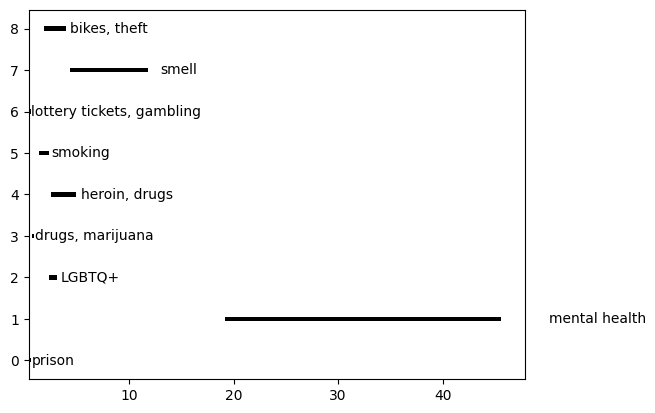

In [80]:
# fig, axs = plt.subplots(len(topics_), figsize=[10,10])

fig, ax = plt.subplots()

# get 99% CI as lower bound and upper bound
bars = []
for i, (tl, tn) in enumerate(topics_):
    
    # get contrasts
    p_poor = trace.posterior[f'p_poor_{tl}'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    p_rich = trace.posterior[f'p_rich_{tl}'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

    pc = p_poor/p_rich
    bars.append([np.percentile(pc, 0.05), np.percentile(pc,99.5), i, tl])

# Plot each bar
for bar in bars:
    # Extract coordinates for each bar and its height
    x1, x2, y, label= bar
    width = x2 - x1
    ax.barh(y, width, left=x1, color='black', height=0.1, label=label )

    if tl in ['mental health']:
        ax.text(x2*1.1, y, label, ha='right', va='center', color='black')
    else:
        ax.text(x2*1.1, y, label, ha='left', va='center', color='black')

In [76]:
df_topic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1830354 entries, 0 to 1904436
Data columns (total 21 columns):
 #   Column                                               Dtype  
---  ------                                               -----  
 0   Document                                             object 
 1   Topic                                                int64  
 2   Name                                                 object 
 3   Representation                                       object 
 4   Representative_Docs                                  float64
 5   Top_n_words                                          object 
 6   Representative_document                              bool   
 7   index                                                object 
 8   police_cops _police officer_cop                      bool   
 9   prison_jail_prisons                                  bool   
 10  fast food_mcdonalds_McDonalds_mcdonald's_McDonald's  bool   
 11  abortion_abortions_birth

## Poor + black + topic samples for RQ2 analysis

In [79]:
# police
import random
random.seed(85)
pool = list(df_topic.loc[
    df_topic.loc[:, 'index'].isin(poor_indices_pure) & 
    df_topic.loc[:, 'index'].isin(black_indices) & 
    (df_topic.loc[:, 'police_cops _police officer_cop ']==True), 
    'Document'
].values)
print(len(pool))

sample = random.sample(pool, k=50)

# with open(f'samples/poor+topic+black/police.txt', 'w') as f:
#     f.write("\n------\n".join(sample))

629


In [81]:
len(df_topic.loc[df_topic.loc[:, 'index'].isin(poor_indices_pure)&df_topic.loc[:, 'index'].isin(black_indices),:])

3836

In [78]:
# prison
import random
random.seed(85)
pool = list(df_topic.loc[
    df_topic.loc[:, 'index'].isin(poor_indices_pure) & 
    df_topic.loc[:, 'index'].isin(black_indices) & 
    (df_topic.loc[:, 'prison_jail_prisons']==True), 
    'Document'
].values)
print(len(pool))

sample = random.sample(pool, k=50)

# with open(f'samples/poor+topic+black/prison.txt', 'w') as f:
#     f.write("\n------\n".join(sample))

348


In [86]:
len(set(n_indices))

73568